In [1]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import Deep learning Libraries
#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

2024-05-02 13:55:11.398198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 13:55:11.398398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 13:55:11.532590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir= '/kaggle/input/leukemia/Original'
filepaths=[]
labels=[]


folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        # Select just tumor name
        fold = str(fold).replace('C+', '')
        labels.append(fold[:-3])

        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

filepaths labels
0     /kaggle/input/leukemia/Original/Pro/WBC-Malign...       
1     /kaggle/input/leukemia/Original/Pro/WBC-Malign...       
2     /kaggle/input/leukemia/Original/Pro/WBC-Malign...       
3     /kaggle/input/leukemia/Original/Pro/WBC-Malign...       
4     /kaggle/input/leukemia/Original/Pro/WBC-Malign...       
...                                                 ...    ...
3251  /kaggle/input/leukemia/Original/Early/WBC-Mali...     Ea
3252  /kaggle/input/leukemia/Original/Early/WBC-Mali...     Ea
3253  /kaggle/input/leukemia/Original/Early/WBC-Mali...     Ea
3254  /kaggle/input/leukemia/Original/Early/WBC-Mali...     Ea
3255  /kaggle/input/leukemia/Original/Early/WBC-Mali...     Ea

[3256 rows x 2 columns]

In [4]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [22]:
# crobed image size
batch_size = 16
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2604 validated image filenames belonging to 3 classes.
Found 391 validated image filenames belonging to 3 classes.
Found 261 validated image filenames belonging to 3 classes.


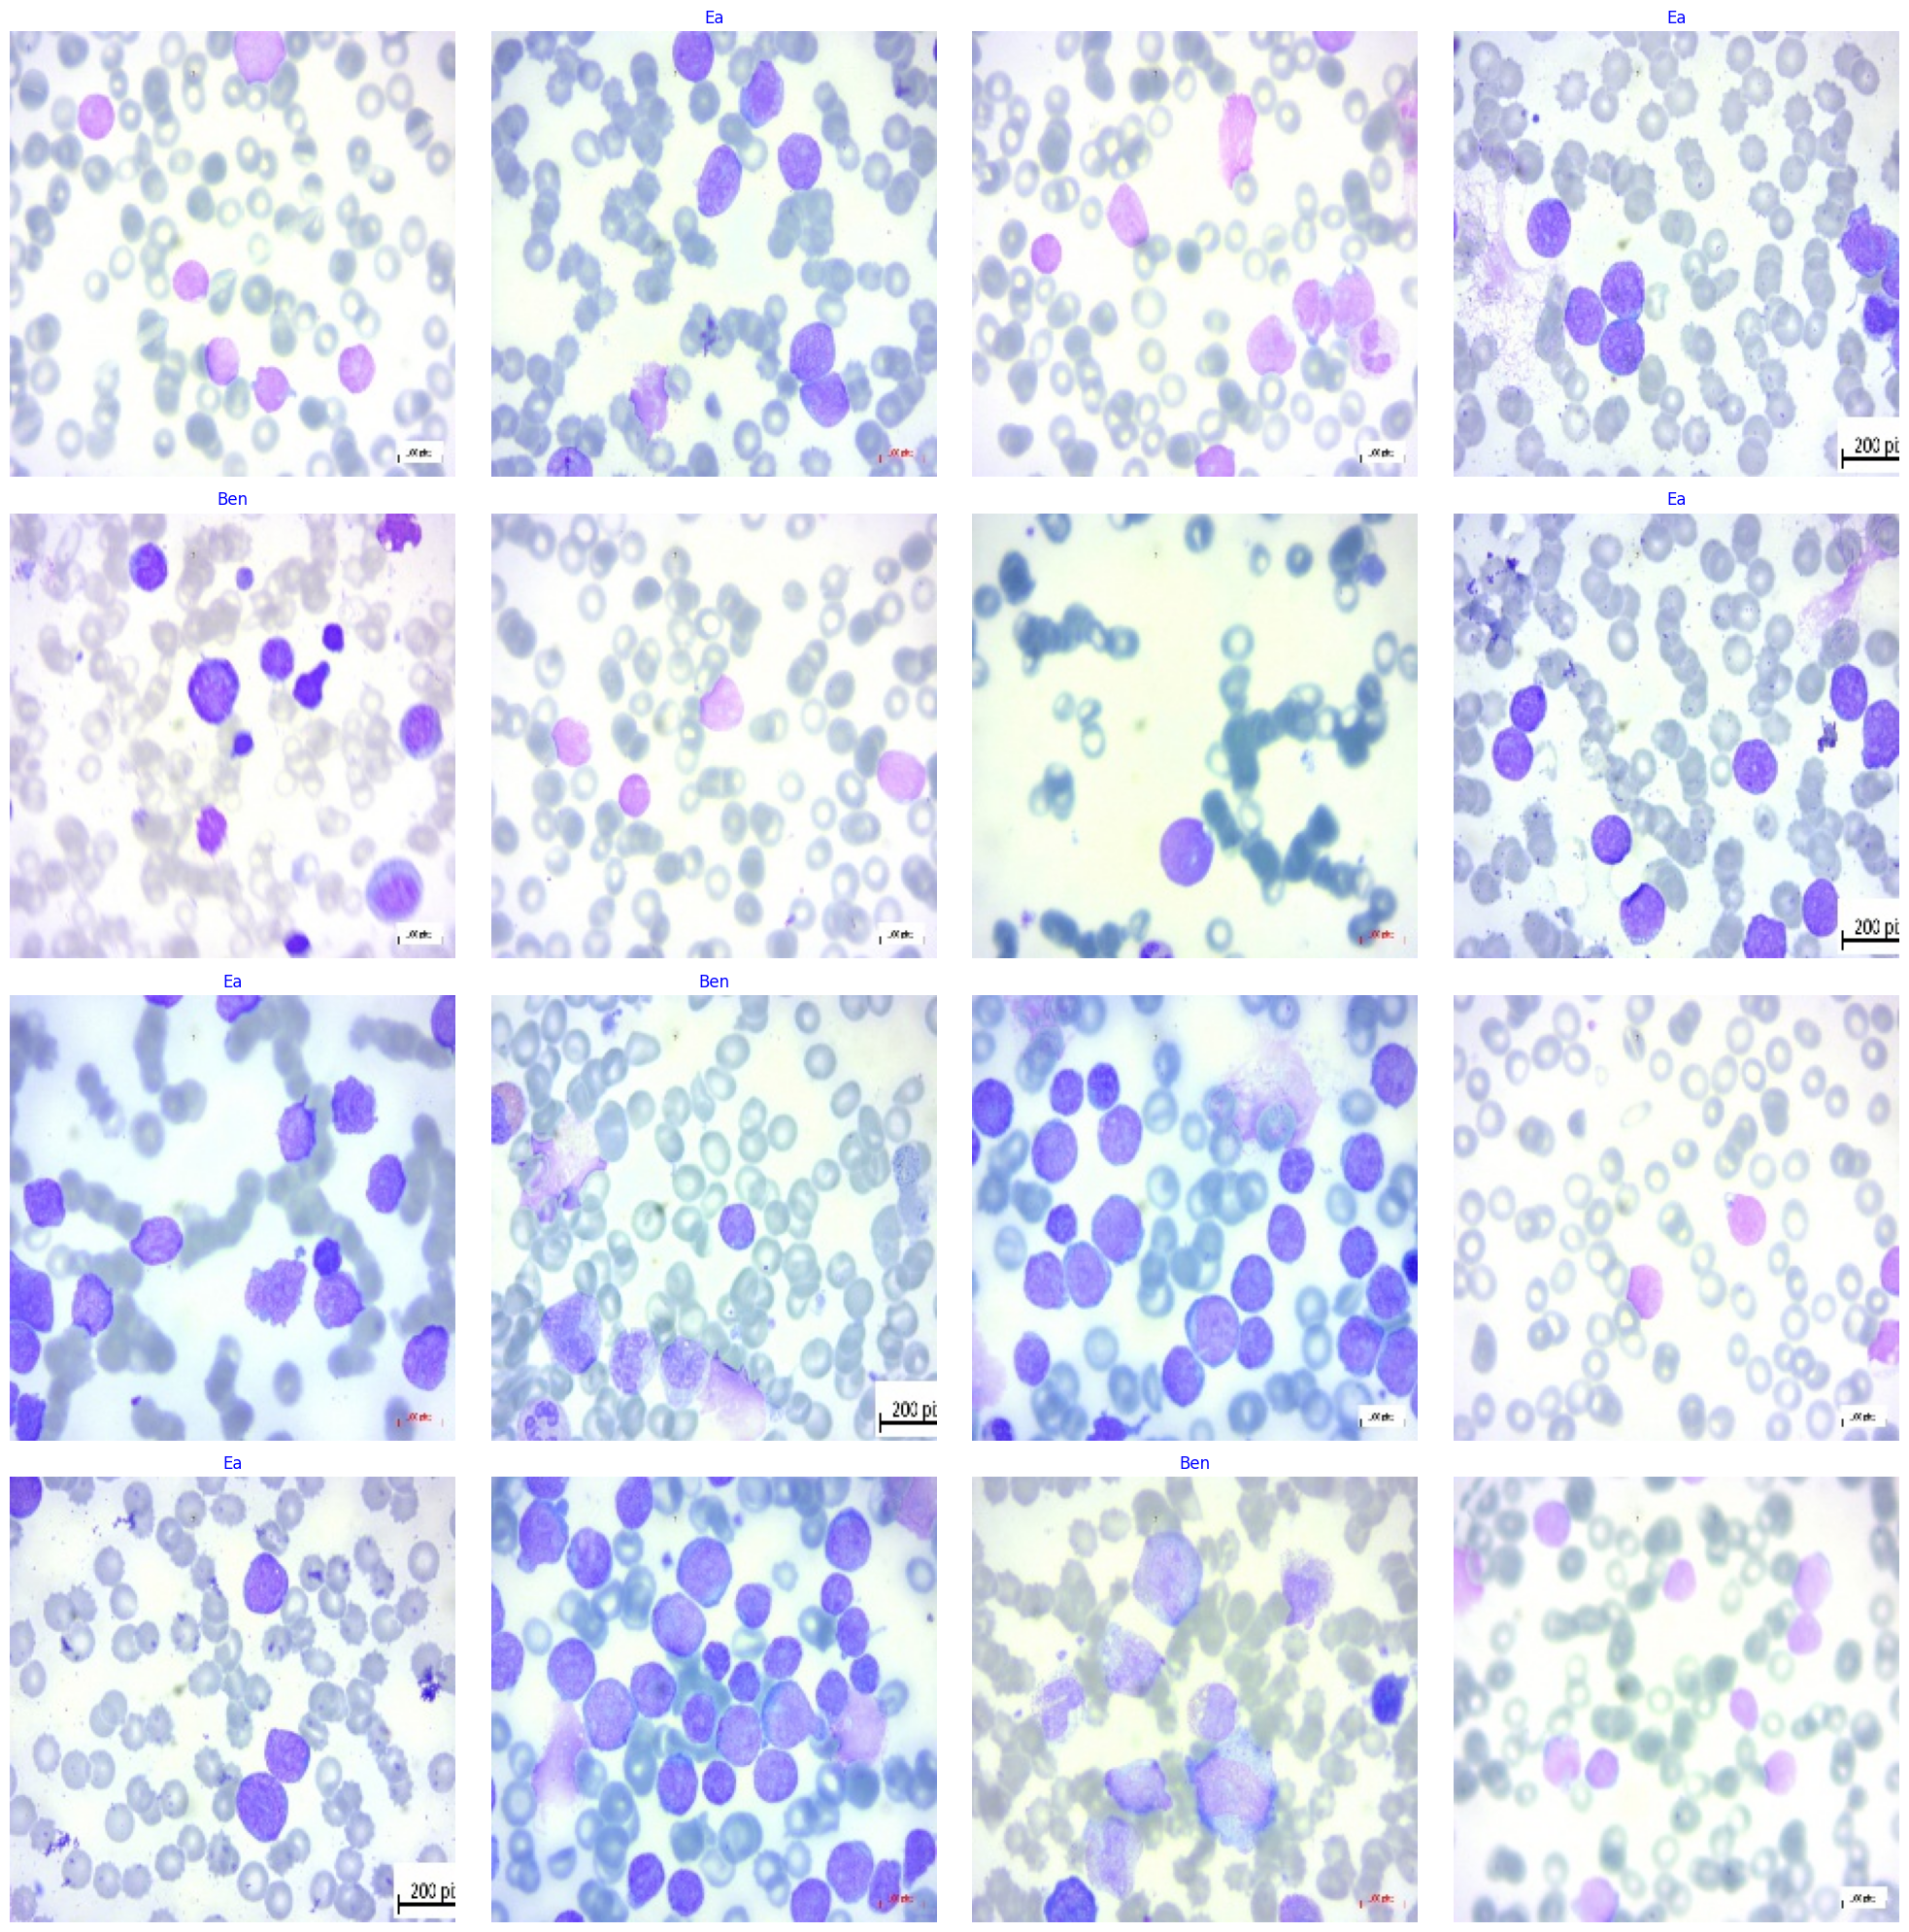

In [6]:
#Samples Of The Data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
#Create Model Structure
from tensorflow.keras.layers import MaxPooling2D
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
base_model = tf.keras.applications.EfficientNetB7(include_top= False, weights= "imagenet", input_shape= img_shape,pooling= 'max',classes=4,classifier_activation="softmax")

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation= 'relu'),
    Dropout(rate= 0.3),
    Dense(class_count, activation= 'softmax')
    
]) 

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [28]:
batch_size = 32   # set batch size for training
epochs = 10  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - accuracy: 0.8059 - loss: 1.8369 - val_accuracy: 0.9565 - val_loss: 0.1709
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 661ms/step - accuracy: 0.9887 - loss: 0.0293 - val_accuracy: 0.9974 - val_loss: 0.0114
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - accuracy: 0.9969 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 660ms/step - accuracy: 0.9949 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 659ms/step - accuracy: 0.9988 - loss: 0.0033 - val_accuracy: 0.9949 - val_loss: 0.0085
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 661ms/step - accuracy: 0.9988 - loss: 0.0025 - val_accuracy: 0.9949 - val_loss: 0.0166
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 660ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9949 - val_loss: 0.0160
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 660ms/step - accuracy: 0.9995 - lo

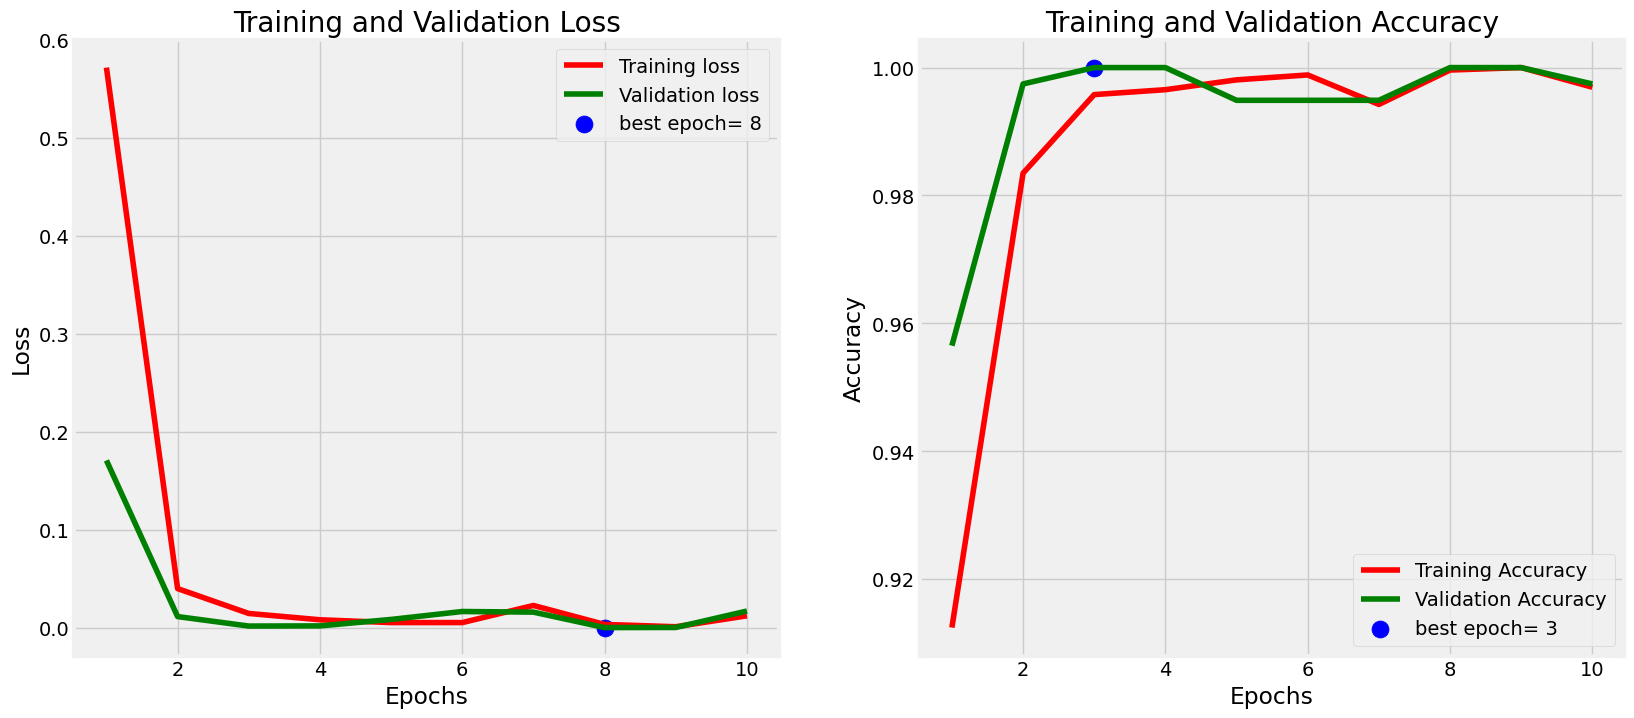

In [29]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

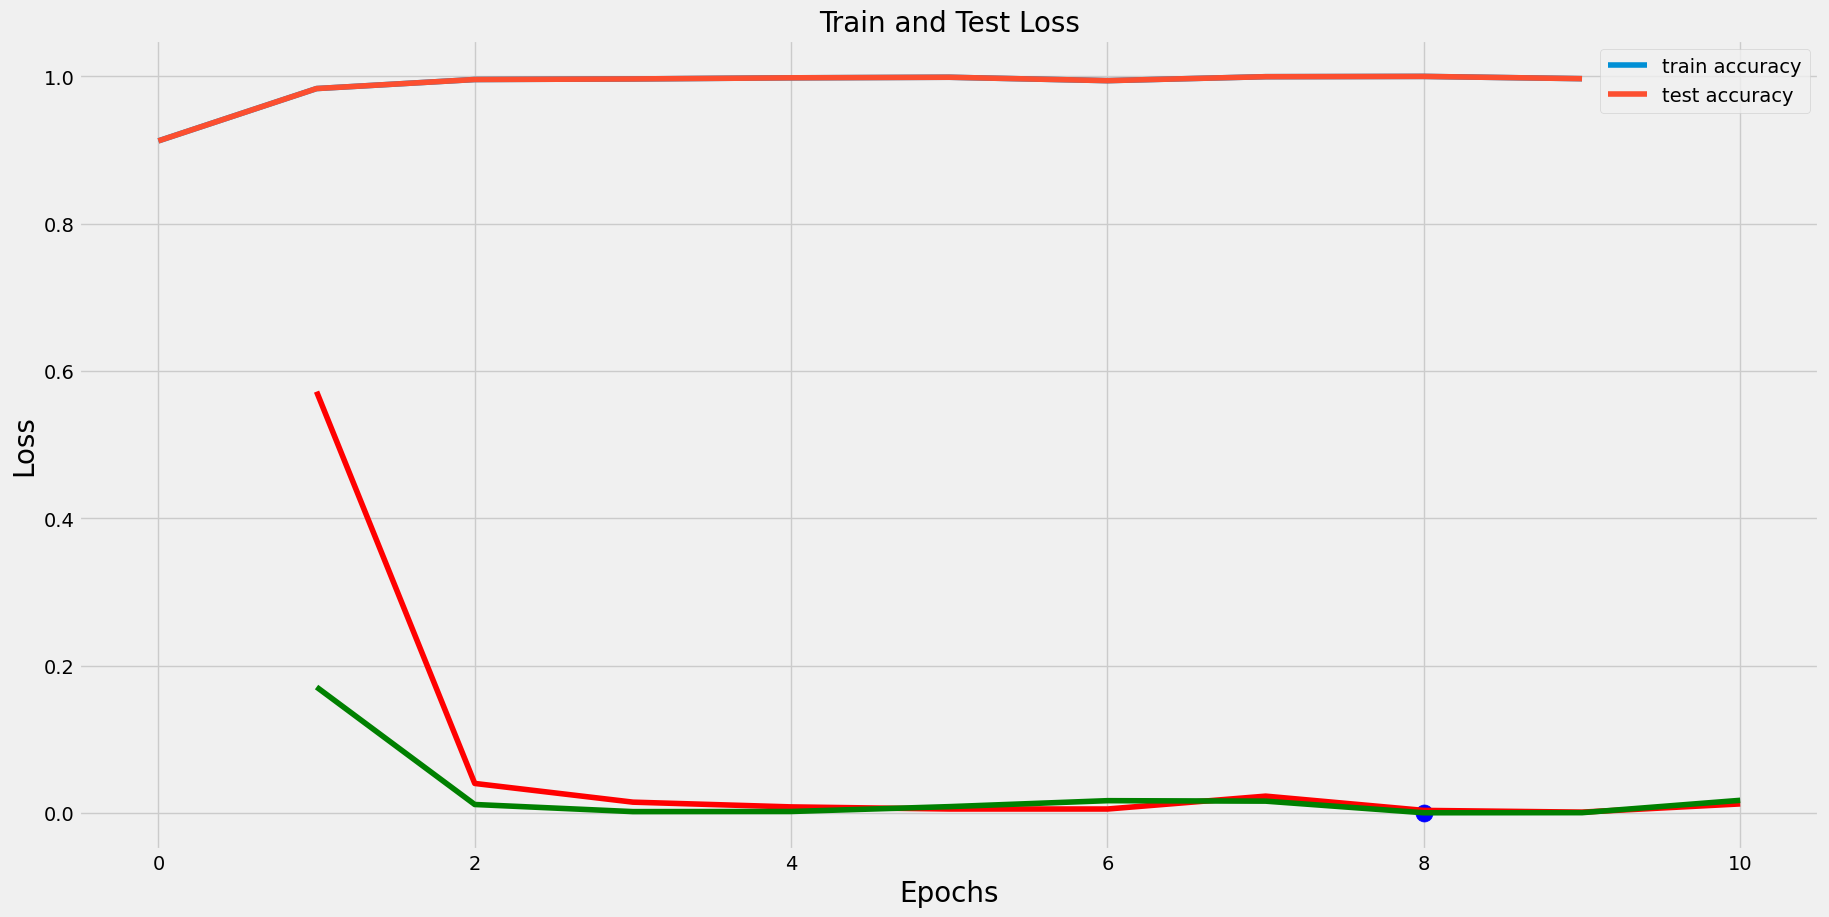

In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc =  history.history['accuracy']
val_acc =  history.history['accuracy']
xc = range(len(tr_acc))

plt.figure(figsize=(20,10))
plt.plot(xc,train_acc,label='train accuracy')
plt.plot(xc,val_acc,label='test accuracy')
plt.legend()
plt.title('Train and Test Loss',size=20)
plt.xlabel('Epochs',size=20)
plt.ylabel('Loss',size=20)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.tight_layout
plt.show()

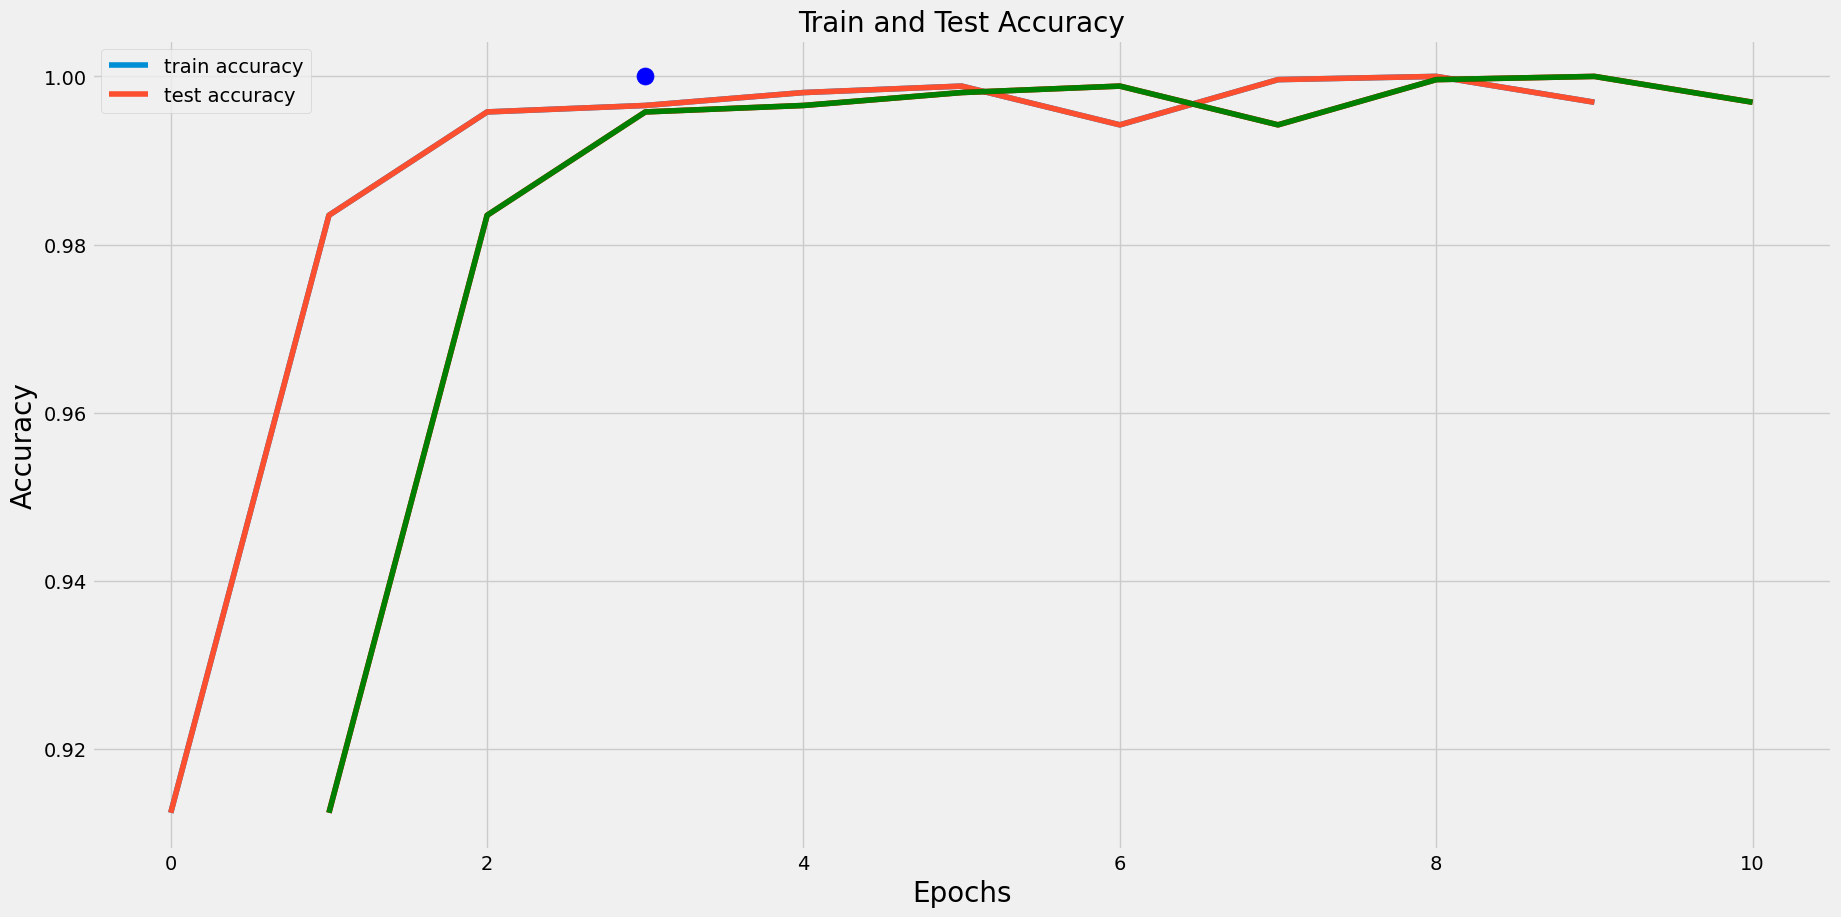

In [31]:
plt.figure(figsize=(20,10))
plt.plot(xc,train_acc,label='train accuracy')
plt.plot(xc,val_acc,label='test accuracy')
plt.legend()
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Train and Test Accuracy',size=20)
plt.xlabel('Epochs',size=20)
plt.ylabel('Accuracy',size=20)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy') 


plt.tight_layout
plt.show()

In [32]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 6.8734e-06
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.9946 - loss: 0.0342
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 1.4978e-05
Train Loss:  1.862343560787849e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04631190001964569
Validation Accuracy:  0.9930555820465088
--------------------
Test Loss:  1.4310960978036746e-05
Test Accuracy:  1.0


In [40]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step 


In [41]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

                   1.00      1.00      1.00       149
         Ben       1.00      1.00      1.00        32
          Ea       1.00      1.00      1.00        80

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



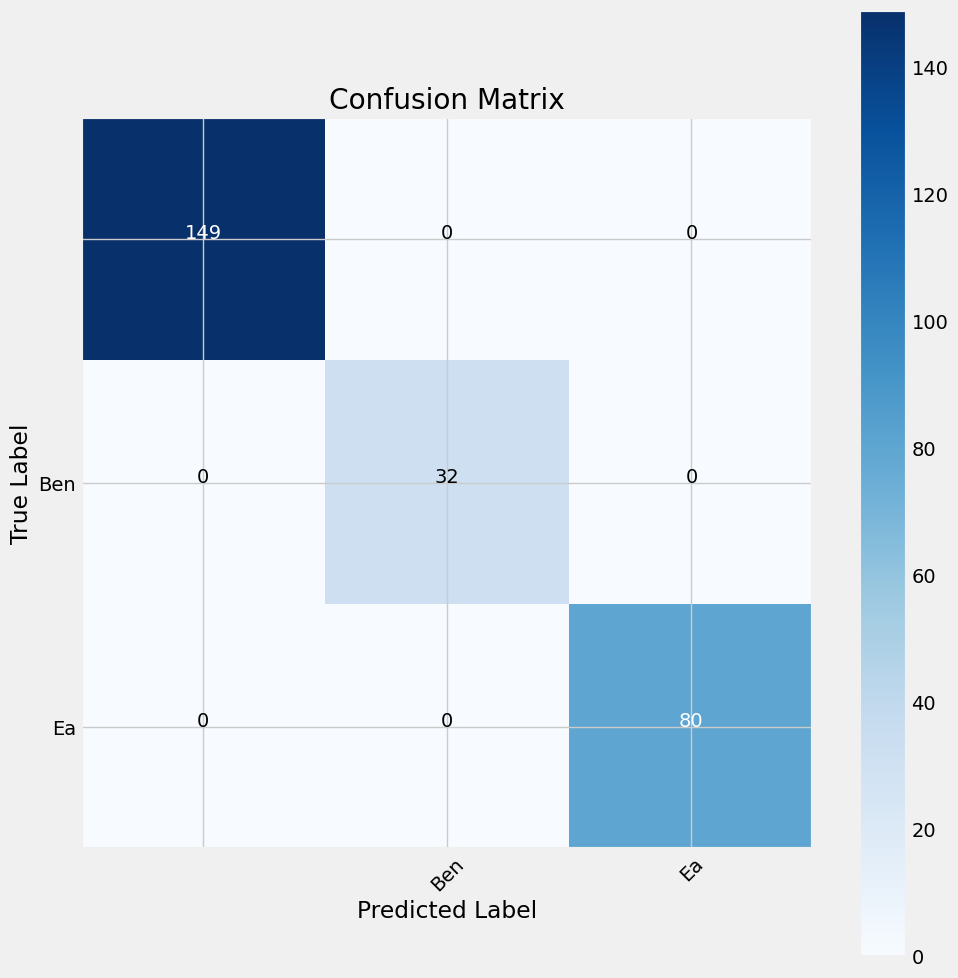

In [42]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [49]:
model.save('113.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [51]:
loaded_model = tf.keras.models.load_model('/kaggle/working/Acute Lymphoblastic Leukemia (ALL).h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 2560), dtype=float32, sparse=False, name=keras_tensor_7931>'],)
  • kwargs=<class 'inspect._empty'>

In [52]:
image_path = '/kaggle/input/leukemia/Segmented/Benign/WBC-Benign-001.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

NameError: name 'loaded_model' is not defined